In [16]:
import tensorflow as tf
import keras
from DataGenerator import DataGenerator
from losses_and_metrics import accuracy, recall, loss_with_negative_mining, wrapped_partial, compute_one_by_N
import sys
from keras.applications.vgg16 import preprocess_input
sys.path.append('../data_preprocessing/')
from ground_truth import GTBuilder
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_classes = 21
aspect_ratios = [1, 2, 3, 1 / 2.0, 1 / 3.0]
num_aspect_ratios = len(aspect_ratios)+1 # +1 for the last box with aspect_ratio 1 but bigger size

feature_sizes = [28, 14]
batch_size = 1
k = 10

In [3]:
loss_fun = wrapped_partial(loss_with_negative_mining, k=k, num_aspect_ratios=num_aspect_ratios, num_classes=num_classes)
acc_fun = wrapped_partial(accuracy, num_aspect_ratios=num_aspect_ratios, num_classes=num_classes)
recall_fun = wrapped_partial(recall, num_aspect_ratios=num_aspect_ratios, num_classes=num_classes)

In [5]:
model = keras.models.load_model("VGG_basic_2", custom_objects={'loss_with_negative_mining': loss_fun, 
                                                            'accuracy':acc_fun,
                                                            'recall':recall_fun})

y_true Tensor("28_target:0", shape=(?, ?, ?, ?), dtype=float32) y_pred Tensor("28/BiasAdd:0", shape=(?, 28, 28, 126), dtype=float32)
After reshape and slicing: y_true Tensor("metrics/accuracy/Slice:0", shape=(?, ?, ?, 6), dtype=float32) y_pred Tensor("metrics/accuracy/Reshape:0", shape=(?, ?, ?, 6, 21), dtype=float32)
Final: y_true Tensor("metrics/accuracy/one_hot:0", shape=(?, 21), dtype=float32) y_pred Tensor("metrics/accuracy/Reshape_1:0", shape=(?, 21), dtype=float32)
Tensor("metrics/recall/Squeeze:0", dtype=int64)
y_true Tensor("14_target:0", shape=(?, ?, ?, ?), dtype=float32) y_pred Tensor("14/BiasAdd:0", shape=(?, 14, 14, 126), dtype=float32)
After reshape and slicing: y_true Tensor("metrics/accuracy_1/Slice:0", shape=(?, ?, ?, 6), dtype=float32) y_pred Tensor("metrics/accuracy_1/Reshape:0", shape=(?, ?, ?, 6, 21), dtype=float32)
Final: y_true Tensor("metrics/accuracy_1/one_hot:0", shape=(?, 21), dtype=float32) y_pred Tensor("metrics/accuracy_1/Reshape_1:0", shape=(?, 21), dtype

In [6]:
print model.outputs

[<tf.Tensor '28/BiasAdd:0' shape=(?, 28, 28, 126) dtype=float32>, <tf.Tensor '14/BiasAdd:0' shape=(?, 14, 14, 126) dtype=float32>]


In [7]:
data_gen = DataGenerator(data_dir='../data/VOCdevkit/VOC2012/JPEGImages/', 
                        label_dir='../data/VOCdevkit/VOC2012/Preprocessed/', 
                        num_classes=num_classes, num_aspect_ratios=num_aspect_ratios,
                        feature_sizes=feature_sizes, 
                        batch_size=batch_size)

(17125,)


In [8]:
batch = data_gen.generate(train=False).next()

In [9]:
# batch

In [10]:
preds = model.predict(batch[0])

In [11]:
print batch[1]['28'].nonzero()

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [12]:
print len(preds), preds[0].shape, preds[1].shape
print preds[0].nonzero()

2 (1, 28, 28, 126) (1, 14, 14, 126)
(array([0, 0, 0, ..., 0, 0, 0]), array([ 0,  0,  0, ..., 27, 27, 27]), array([ 0,  0,  0, ..., 27, 27, 27]), array([  0,   1,   2, ..., 123, 124, 125]))


In [13]:
pred_dict = {'28':preds[0], '14':preds[1]}

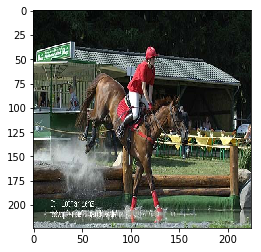

In [17]:
image_file = '../data/VOCdevkit/VOC2012/JPEGImages/2007_000392.jpg'
img = Image.open(image_file)
img = img.resize((224, 224))

plt.imshow(img)

In [18]:
def draw_boxes(im, boxes):
#     fig,ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(im)
    
    for box in boxes:
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(im)
#         print box.__dict__
        x_top = max(box.xc - box.width/2.0, 0)
        y_top = max(box.yc - box.height/2.0, 0)
        # Create a Rectangle patch
        rect = patches.Rectangle((x_top, y_top), box.width, box.height,
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.ylabel(box.object_type)
        plt.show()

#     plt.show()

In [19]:
classes = ["background", "person", "bird", "cat", "cow", "dog", "horse", "sheep", "aeroplane", "bicycle", "boat", "bus",
               "car", "motorbike", "train", "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]
num_classes = len(classes)
num_scales = num_aspect_ratios
class_to_index = {key: value for (key, value) in zip(classes, range(num_classes))}
gt_builder = GTBuilder(feature_sizes, aspect_ratios, num_scales, class_to_index)

In [20]:
X = np.copy(np.expand_dims(img, 0)).astype(np.float64)
scores = model.predict(preprocess_input(X))
print (scores[0].shape)
preds_dict = {}
for score in scores:
    score_shape = score.shape
    score = np.reshape(score, (score_shape[1], score_shape[2], num_scales, num_classes))
    preds = np.argmax(score, axis=-1)
    print preds.shape
    print np.sum(preds>0)
    print preds
    preds_dict[str(score_shape[1])] = preds

(1, 28, 28, 126)
(28, 28, 6)
534
[[[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 ..., 
 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]]
(14, 14, 6)
143
[[[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ..., 
  [0 0 0 1 1 0]
  [0 0 0 0 0 0]
  [0 0 0

28


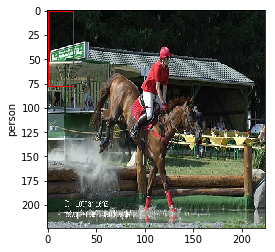

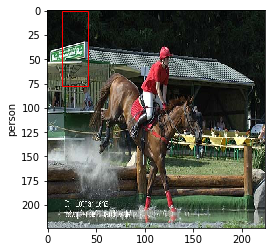

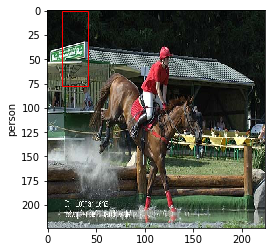

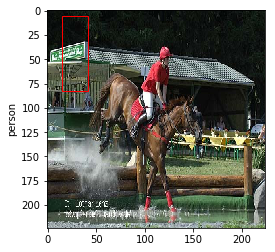

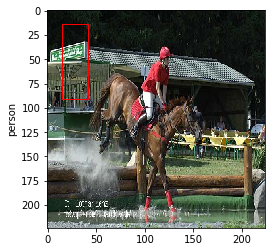

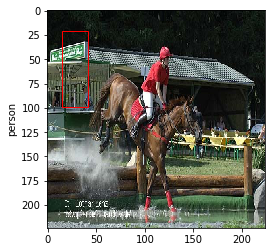

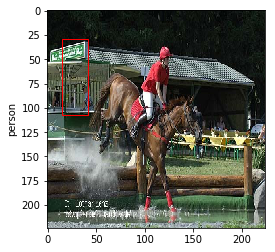

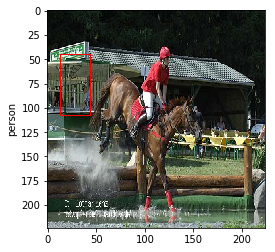

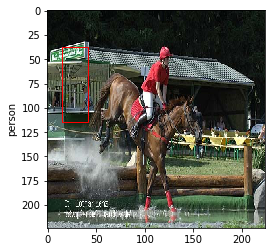

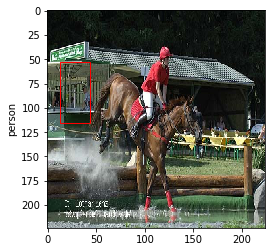

In [ ]:
for key in preds_dict:
    gt_map = preds_dict[key]
    key = int(key)
    
    feature_index = feature_sizes.index(key)
    x, y, z = np.where(gt_map > 0)
    indices = zip(x, y, z)
    boxes = []
    for index in indices:
        bbox = gt_builder.index_to_bbox(*(list(index) + [feature_index]))
        bbox.object_type = classes[gt_map[index]]
        boxes.append(bbox)
#         break
    print key
    draw_boxes(img, boxes)